In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import statsmodels.stats.multicomp as multi
from scipy.stats import bootstrap
from statsmodels.stats.multicomp import pairwise_tukeyhsd as multi_pairwise_tukeyhsd
from scipy.stats import ks_2samp
import seaborn as sns
from v1dd_public import ARTIFACT_DIR
from allen_v1dd.client import OPhysClient
from pathlib import Path
import h5py
from allen_v1dd.stimulus_analysis.natural_scenes import NaturalScenes
from matplotlib.colors import LinearSegmentedColormap

In [3]:
H5_DIR = Path(f"{ARTIFACT_DIR}/stimulus_analyses_v2.h5")

In [4]:
colors = [
    '#FF5733',  # Red
    '#33FF57',  # Green
    '#3357FF',  # Blue
    '#F1C40F',  # Yellow
    '#9B59B6',  # Purple
    'cyan',     # Cyan, named color
    'magenta',  # Magenta, named color
    '#FFC300',  # Gold
    '#DAF7A6',  # Light Green
    '#581845',  # Dark Purple
    '#34495E',  # Asphalt
    '#16A085',  # Green Sea
    '#E74C3C',  # Red Orange
    '#2980B9',  # Belize Hole Blue
    'chocolate' # Chocolate, named color
]

mouse_colors = {'slc2': 'red', 'slc4': 'blue', 'slc5': 'orange', 'teto1': 'green'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
z_groups_high_to_low = [[650, 675, 700, 725], [575, 600, 625], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]


In [5]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [6]:
n_stimulus_pairs = 8
n_bootstrap = 1000
n_samples = 50
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
bootstrapped_data = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups, n_mice))

            
fontsize = 14
total_samples_per_group = [0] * len(z_groups_high_to_low)

titles = ['ns12_ls', 'ns118_ls', 'nm_ls']
for subplot_idx in range(n_stimulus_pairs):   
    for m, mouse_id in enumerate(mice):
 
        for z, z_group in enumerate(z_groups_high_to_low):
                plane = (cell_info['z'].isin(z_group)) & (cell_info['mouse_id']==mice[m])
                plane_df = cell_info[plane]
                
                for b in range(n_bootstrap):
                    sample_indices = np.random.choice(range(len(plane_df)), size=n_samples, replace=True)
                    sample_plane_df = plane_df.iloc[sample_indices]

                    if subplot_idx == 0:
                        stim_plane = (sample_plane_df['ns12_ls'])
                    elif subplot_idx == 1:
                        stim_plane = (sample_plane_df['ns118_ls'])
                    elif subplot_idx == 2:
                        stim_plane = (sample_plane_df['nm_ls'])

                    stim_plane_df = stim_plane

                    if len(stim_plane_df):
                        data = stim_plane_df.dropna().to_numpy()
                        bootstrapped_data[subplot_idx, b, z, m] = np.median(data) 

In [7]:
def perform_anova(filtered_data):

    f_value, p_value = stats.f_oneway(*filtered_data)
    return f_value, p_value

def perform_tukeys_hsd_and_top_pairs(filtered_data):

    all_data = np.concatenate(filtered_data)
    groups = np.concatenate([np.full(len(sublist), i) for i, sublist in enumerate(filtered_data)])
    tukey_result = multi.pairwise_tukeyhsd(all_data, groups, 0.05)
    tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
    significant_pairs = tukey_df[tukey_df['p-adj'] < 0.05]
    significant_pairs_sorted = significant_pairs.sort_values(by='p-adj')


    print("\nTukey's HSD test result:")
    print(tukey_result)
    print(f"\nPairs with p-values < 0.05: {len(significant_pairs_sorted)} found")
    print(significant_pairs_sorted)
    
    return tukey_result, significant_pairs_sorted.to_records(index=False)

/tmp/ipykernel_4117068/2925756498.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]


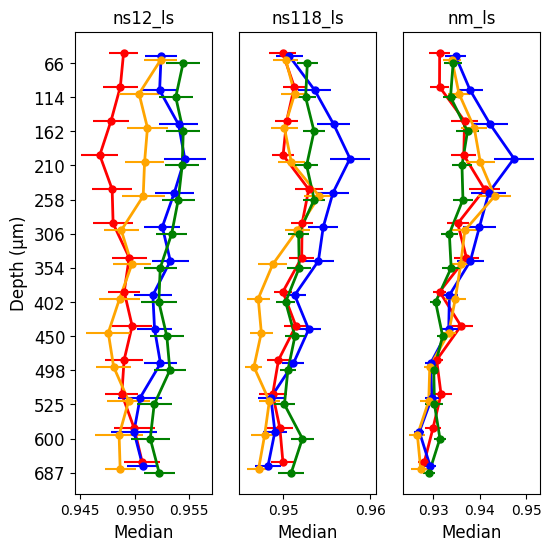

In [8]:
n_stimulus_pairs=3
jitter_amount = 0.15
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))

fig = plt.figure(figsize=(6, 6))
for s in range(n_stimulus_pairs):
    ax = plt.subplot(1, n_stimulus_pairs, s + 1)
    
    for m, mouse_id in enumerate(mice):

        means = []
        std_errors = []
        mouse_color = mouse_colors[mice[m]]
        
        for z in range(n_z_groups):
            bootstrapped_values = bootstrapped_data[s, :, z, m]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)
 
        base_y_positions = np.arange(1, len(means) + 1)
        jitter = fixed_jitters[:, 3-m]
        y_positions = base_y_positions + jitter
        plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=5)
        plt.plot(means, y_positions, color=mouse_color, linewidth=2)

        plt.xlabel('Median', fontsize=12)
        plt.title(titles[s])
    
    if s == 0:
        y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]
        plt.yticks(y_positions, y_tick_labels, fontsize=12)
        plt.ylabel("Depth (µm)", fontsize=12)
    else:
        plt.yticks([])

# plt.show()
# fig.savefig(f"ns_nm_depth_plots.eps", format='eps')

Run the bootstrapping again regardless of the mouse id to run the statistics

In [34]:
n_stimulus_pairs = 8
n_bootstrap = 1000
n_samples = 50
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
bootstrapped_data = np.zeros((n_stimulus_pairs, n_bootstrap, n_z_groups))
            
fontsize = 14
total_samples_per_group = [0] * len(z_groups_high_to_low)

titles = ['ns12_ls', 'ns118_ls', 'nm_ls']
for subplot_idx in range(n_stimulus_pairs):   
 
        for z, z_group in enumerate(z_groups_high_to_low):
                plane = (cell_info['z'].isin(z_group))
                plane_df = cell_info[plane]
                
                for b in range(n_bootstrap):
                    sample_indices = np.random.choice(range(len(plane_df)), size=n_samples, replace=True)
                    sample_plane_df = plane_df.iloc[sample_indices]

                    if subplot_idx == 0:
                        stim_plane = (sample_plane_df['ns12_ls'])
                    elif subplot_idx == 1:
                        stim_plane = (sample_plane_df['ns118_ls'])
                    elif subplot_idx == 2:
                        stim_plane = (sample_plane_df['nm_ls'])

                    stim_plane_df = stim_plane
                    
                    if len(stim_plane_df):
                        data = stim_plane_df.dropna().to_numpy()
                        bootstrapped_data[subplot_idx, b, z] = np.median(data)

/tmp/ipykernel_4117068/495947301.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]


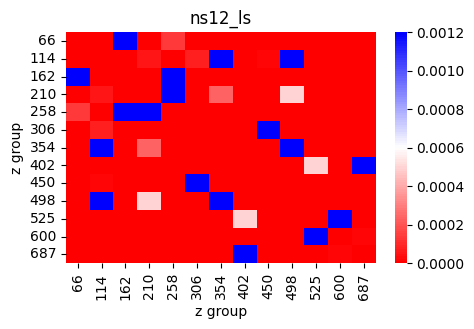

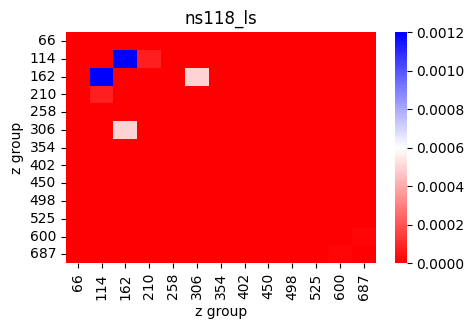

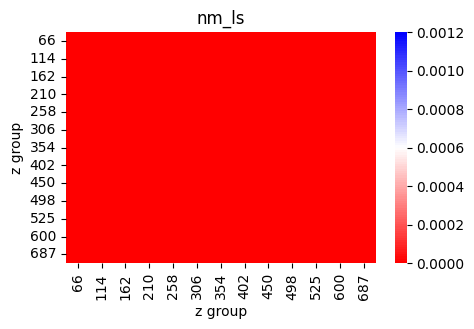

In [36]:
colors = ["red", "white", "blue"]
n_bins = 100
cmap_name = "custom_colormap"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
p_val = 0.0006#0.05/78
vmin, vmax = 0, p_val*2
norm = plt.Normalize(vmin=vmin, vmax=vmax)
p_value_matrix = np.ones((13, 13))
y_tick_labels = [np.int(np.mean(group)) for group in z_groups_high_to_low]
y_tick_labels = np.flip(y_tick_labels)

for s in range(3):
    data_to_plot = [bootstrapped_data[s, :, z] for z in range(n_z_groups)]
    significant_pairs = []
    # Pairwise Kolmogorov-Smirnov tests
    for i in range(len(data_to_plot)):
        for j in range(i+1, len(data_to_plot)):
            ks_stat, p_value = ks_2samp(data_to_plot[i], data_to_plot[j])

            if p_value < p_val:
                significant_pairs.append((i, j, p_value))
                p_value_matrix[j, i] = p_value
                p_value_matrix[i, j] = p_value

    np.fill_diagonal(p_value_matrix, 0)
    plt.figure(figsize=(5, 3))
    p_value_matrix = np.flip(np.flip(p_value_matrix, axis=0), axis=1)
    sns.heatmap(p_value_matrix, annot=False, cmap=cm, norm = norm, cbar=True,
                 xticklabels=y_tick_labels, yticklabels=y_tick_labels)
    plt.title(titles[s])
    plt.xlabel('z group')
    plt.ylabel('z group')
    plt.show()

### Check the stimuli details for natural movie

The natural movie stimulus for the slc2 and TetO1 mice consisted of 3,600 frames (with 30 Hz frame rate) and was presented 8 times. For slc4 and slc5 mice, the natural movie stimulus consisted of 900 frames presented 30 times.


mice = ['slc2', 'slc4', 'slc5', 'teto1']

mouse_ids = ["M409828", "M416296", "M427836", "M438833"]

slc2: 3600 frames x 8 times (total 29700)

slc4: 3600 frames x 9 times (total 29700)

slc5: 900 frames x 10 times (total 9000)

teto1: 900 frames x 30 times (total 27000)

In [32]:
DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()

mouse_id = 'M427836'  #slc5
col_vol_id = "11"
plane = 2
plane_name = f"Plane_{plane}"
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_id}")
stim_table_tuple = session.get_stimulus_table("natural_movie")
stim_table = stim_table_tuple[0]
len(stim_table)

9000